<a href="https://colab.research.google.com/github/sookyannnn/SIEW-2022-Economic-Geography-in-East-Asia-and-Pacfic/blob/main/CH02_Economic_Inequality_(Hierarchical_Clustering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [ ]:
pip install pysal # run this cell first and restart runtime then run all

In [ ]:
pip install contextily

# Load Packages

In [ ]:
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn 
import pandas
import geopandas 
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

# Load Dataset

1.   Duplicate this Google Drive folder : https://drive.google.com/drive/folders/1C0lNnGSsCGdQ8kC-gGEBYt8L9UeAaNcv?usp=sharing
2.   Mount Google Drive to Google Collab

## Satellite Nightlight

In [ ]:
satellite = gpd.read_file("/content/drive/MyDrive/SIEW (2022) Economic Geography in East Asia and Pacfic/Dataset/satellite.gpkg") 


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [ ]:
# Inspect the structure of the table
satellite.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13825 entries, 0 to 13824
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          13825 non-null  int64   
 1   region      13799 non-null  object  
 2   country     13825 non-null  object  
 3   name        13825 non-null  object  
 4   econ_2005   13825 non-null  float64 
 5   econ_2018   13825 non-null  float64 
 6   popdens_05  13469 non-null  float64 
 7   popdens_18  13469 non-null  float64 
 8   X           13825 non-null  float64 
 9   Y           13825 non-null  float64 
 10  geometry    13825 non-null  geometry
dtypes: float64(6), geometry(1), int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
# compute weight matrix (knn8)
w = weights.KNN.from_dataframe(satellite, k=8)
w

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


In [ ]:
# create subsets
econ05 = ['econ_2005']
econ18 = ['econ_2018']

# Hierarchical Clustering

In [ ]:
# Set seed for reproducibility
numpy.random.seed(0)

# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)

# Run clustering
model.fit(satellite[econ05])

# Assign labels to main data table
satellite['ward5'] =model.labels_

In [ ]:
# check the number of observations that fall within each cluster
ward5sizes = satellite.groupby('ward5').size()
ward5sizes

ward5
0     826
1    1174
2     775
3    9332
4    1718
dtype: int64

In [ ]:
# check the simple average profiles of our clusters:
ward5means = satellite.groupby('ward5')[econ05].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
econ_2005,35.578,15.784,61.114,0.58,7.1


In [ ]:
# tidy data

# Index db on cluster ID
tidy_db = satellite.set_index('ward5')

# Keep only variables used for clustering
tidy_db = tidy_db[econ05]

# Stack column names into a column, obtaining a "long" version of the dataset
tidy_db = tidy_db.stack()

# Take indices into proper columns
tidy_db = tidy_db.reset_index()

# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,0,econ_2005,43.650145
1,3,econ_2005,0.512201
2,1,econ_2005,15.791932
3,0,econ_2005,25.424023
4,3,econ_2005,0.087030


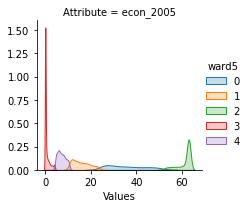

In [ ]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='ward5')

# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()


# save
#plt.savefig("/content/drive/MyDrive/SIEW (2022) Economic Geography in East Asia and Pacfic/Figures/CH02-densplot_2005.png", dpi = 72)

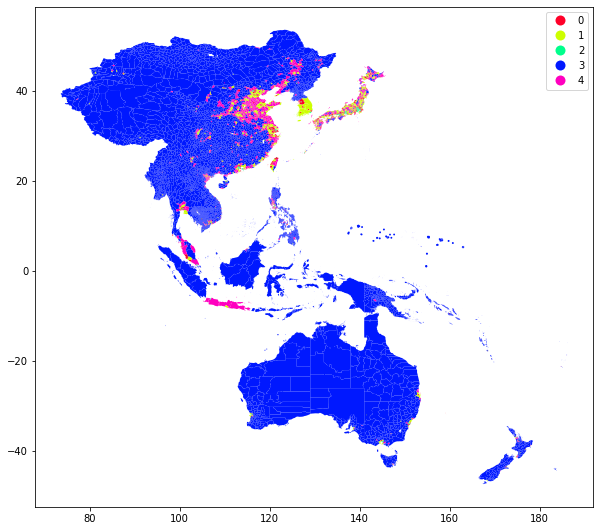

In [ ]:
satellite['econ_2005'] =model.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot unique values choropleth including a legend and with no boundary lines
satellite.plot(column='econ_2005', categorical=True, legend=True, linewidth=0, ax=ax, cmap="gist_rainbow")

# save
#plt.savefig("/content/drive/MyDrive/SIEW (2022) Economic Geography in East Asia and Pacfic/Figures/CH02-Hier_2005.png", dpi = 72)

# Spatially Constrained Hierarchical Clustering

In [ ]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=12)
model.fit(satellite[econ05])

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 20 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<13825x13825 sparse matrix of type '<class 'numpy.float64'>'
	with 110600 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=12)

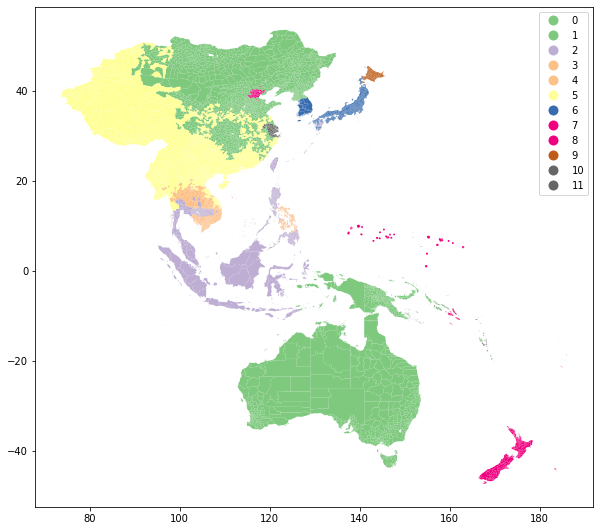

In [ ]:
#inspect output
satellite['econ_2005'] = model.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot unique values choropleth including a legend and with no boundary lines
satellite.plot(column='econ_2005', categorical=True, legend=True, linewidth=0, ax=ax, cmap="Accent" )


# save
#plt.savefig("/content/drive/MyDrive/SIEW (2022) Economic Geography in East Asia and Pacfic/Figures/CH02-Hier_S_2005.png", dpi = 72)



---


# Repeat for year 2018

# Hierarchical Clustering

In [ ]:
# Set seed for reproducibility
numpy.random.seed(0)

# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)

# Run clustering
model.fit(satellite[econ18])

# Assign labels to main data table
satellite['ward5'] =model.labels_

In [ ]:
# check the number of observations that fall within each cluster
ward5sizes = satellite.groupby('ward5').size()
ward5sizes

ward5
0       38
1      964
2        2
3    12571
4      250
dtype: int64

In [ ]:
# check the simple average profiles of our clusters:
ward5means = satellite.groupby('ward5')[econ18].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
econ_2018,119.419,17.578,459.298,1.204,50.547


In [ ]:
# tidy data

# Index db on cluster ID
tidy_db = satellite.set_index('ward5')

# Keep only variables used for clustering
tidy_db = tidy_db[econ18]

# Stack column names into a column, obtaining a "long" version of the dataset
tidy_db = tidy_db.stack()

# Take indices into proper columns
tidy_db = tidy_db.reset_index()

# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,1,econ_2018,10.843784
1,3,econ_2018,0.358696
2,3,econ_2018,3.177131
3,3,econ_2018,7.423065
4,3,econ_2018,0.360220


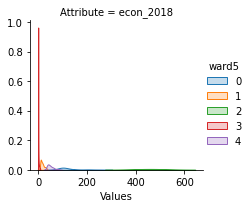

In [ ]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='ward5')

# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()


# save
#plt.savefig("/content/drive/MyDrive/SIEW (2022) Economic Geography in East Asia and Pacfic/Figures/CH02-densplot_2018.png", dpi = 72)

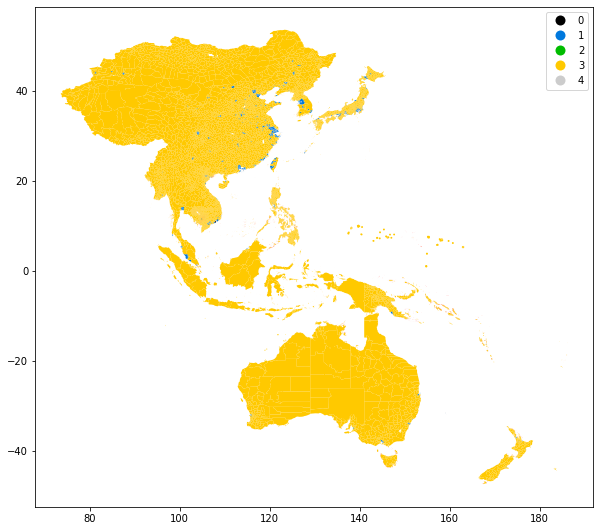

In [ ]:
satellite['econ_2018'] =model.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))

# Plot unique values choropleth including a legend and with no boundary lines
satellite.plot(column='econ_2018', categorical=True, legend=True, linewidth=0, ax=ax, cmap="nipy_spectral" )


# save
#plt.savefig("/content/drive/MyDrive/SIEW (2022) Economic Geography in East Asia and Pacfic/Figures/CH02-Hier_2018.png", dpi = 72)